# HMASR 1°x1° R01 calibration
http://link.springer.com/10.1007/s003820100153

Env: `phd_v3`

In [1]:
# To reload external files automatically (ex: utils)
# phd_v3 env
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
# sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
sys.path.insert(1, '../utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Load data

In [2]:
path = '/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_100km/'

# Snow depth
ds = xr.open_mfdataset(path+'HMA_SR_D_v01_100km_WY*_SD_POST.nc')
sd = ds.SD_Post.load()

# SCF
ds = xr.open_mfdataset(path+'HMA_SR_D_v01_100km_WY*_SWE_SCA_POST.nc')
swe = ds.SWE_Post.load()
scf= ds.SCA_Post.load()

# Mask
mask = xr.open_dataarray('Non_seasonal_snow_mask_100km.nc').load()

# Topo
latlim = slice(mask.lat.min().values.item(0)-0.5, mask.lat.max().values.item(0)+0.5)
lonlim = slice(mask.lon.min().values.item(0)-0.5, mask.lon.max().values.item(0)+0.5)

ds = xr.open_dataset('../data/HMASR_DEM_100km.nc')
topo = ds.elevation_seassnow.load()
topo_std = ds.std_seassnow.load()

## Make plot functions

### Compute weights
Taking into account:
- cos(lat)
- fraction of seasonal snow in a grid cell
- exclude cells with >30% of permanent snow

Weigths used to compute metrics (but not for optimization? -> maybe)

In [4]:
lat_weights = np.cos(np.deg2rad(scf.lat))
frac_seasonal_snow = (1-mask/100).where(scf[0]*0+1 == 1)
temp = (frac_seasonal_snow*lat_weights).where(mask<30)
weights = (temp / temp.sum()).fillna(0)
np.testing.assert_equal(weights.sum().values.item(0), 1)

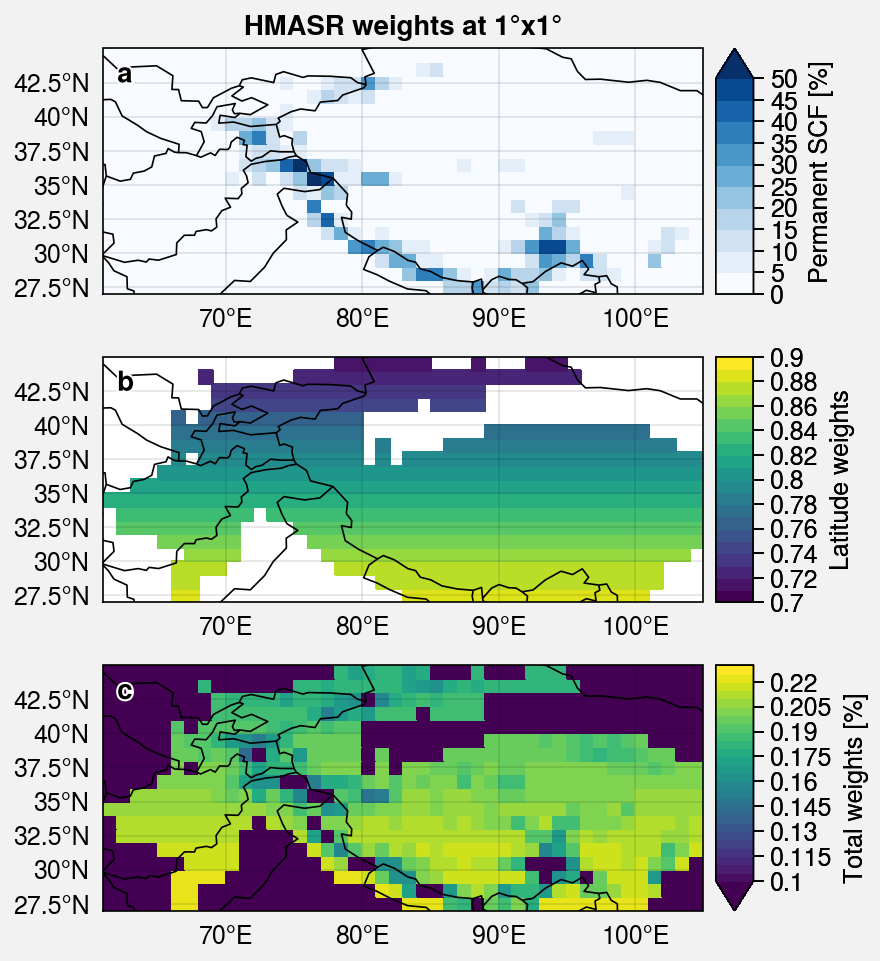

In [5]:
fig, axs = plot.subplots(proj='cyl', ncols=1, nrows=3, axwidth=3)

threshold = 30 # percentage of permanent snow in a cell

axs[0].pcolormesh(mask, levels=plot.arange(0, 50, 5), extend='max', cmap='Blues',
                 colorbar='r', colorbar_kw={'label': 'Permanent SCF [%]'})

axs[1].pcolormesh((scf[0]*0+1)*lat_weights, levels=plot.arange(0.7, 0.9, 0.01), cmap='viridis',
                 colorbar='r', colorbar_kw={'label': 'Latitude weights'})

axs[2].pcolormesh(weights*100, levels=plot.arange(0.0010, 0.0023, 0.00005)*100, cmap='viridis', extend='min',
                 colorbar='r', colorbar_kw={'label': 'Total weights [%]'})

# Format
axs.format(
    borders=True, labels=True, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    suptitle='HMASR weights at 1°x1°',
    abc=True, abcloc='ul'
)

# fig.save('img/weights.jpg')

### Check zones

In [6]:
# Get zone limits for annual cycle
lonlim_TS, latlim_TS, lonlim_HK, latlim_HK, lonlim_TP, latlim_TP, lonlim_HM, latlim_HM = u.get_zones()

# HMA for full domain and the following for the above zones
zones = ['HMA', 'TS', 'HK', 'TP', 'HM']
zones_df = pd.DataFrame(
    [[lonlim, latlim], [lonlim_TS, latlim_TS], [lonlim_HK, latlim_HK], [lonlim_TP, latlim_TP], [lonlim_HM, latlim_HM]], 
    columns=pd.Index(['lonlim', 'latlim'], name='Limits'),
    index=pd.Index(zones, name='Zones')
)

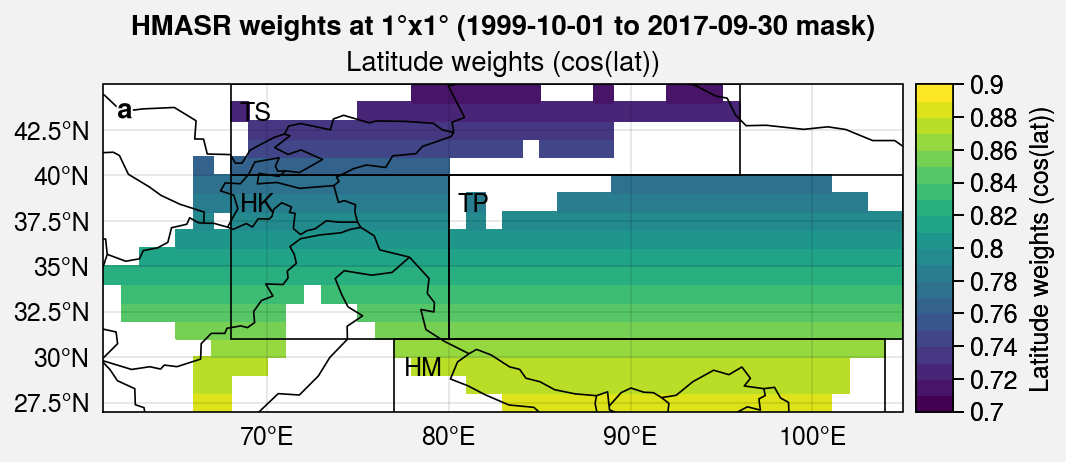

In [7]:
fig, axs = plot.subplots(proj='cyl', ncols=1, nrows=1, axwidth=4)

threshold = 30 # percentage of permanent snow in a cell

axs[0].pcolormesh(((scf[0]*0+1)*lat_weights), 
                  levels=plot.arange(0.7, 0.9, 0.01), cmap='viridis',
                 colorbar='r', colorbar_kw={'label': 'Latitude weights (cos(lat))'})
axs[0].format(title='Latitude weights (cos(lat))')

u.plot_zones(axs[0])

# Format
axs.format(
    borders=True, labels=True, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    suptitle='HMASR weights at 1°x1° (1999-10-01 to 2017-09-30 mask)',
    abc=True, abcloc='ul'
)

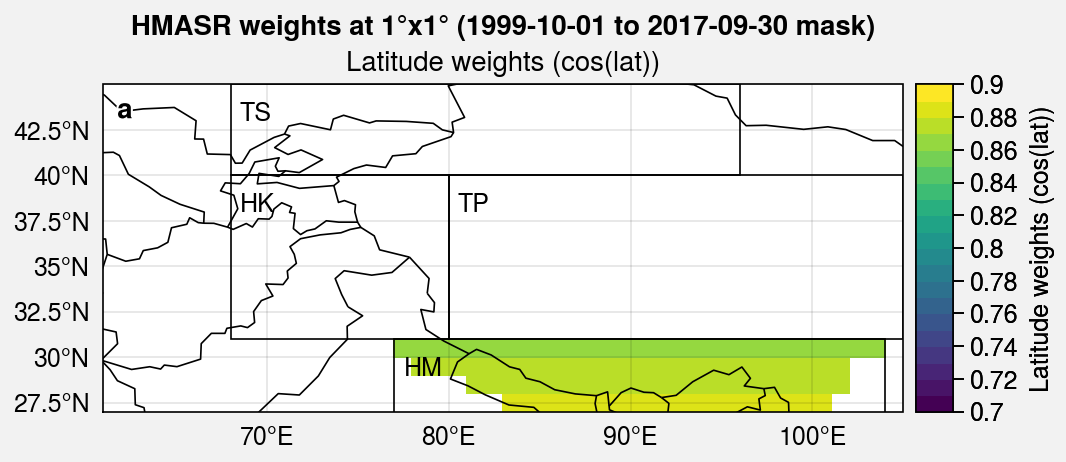

In [8]:
fig, axs = plot.subplots(proj='cyl', ncols=1, nrows=1, axwidth=4)

threshold = 30 # percentage of permanent snow in a cell

axs[0].pcolormesh(((scf[0]*0+1)*lat_weights).sel(lat=latlim_HM, lon=lonlim_HM), 
                  levels=plot.arange(0.7, 0.9, 0.01), cmap='viridis',
                 colorbar='r', colorbar_kw={'label': 'Latitude weights (cos(lat))'})
axs[0].format(title='Latitude weights (cos(lat))')

u.plot_zones(axs[0])

# Format
axs.format(
    borders=True, labels=True, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    suptitle='HMASR weights at 1°x1° (1999-10-01 to 2017-09-30 mask)',
    abc=True, abcloc='ul'
)

### SCF vs SD

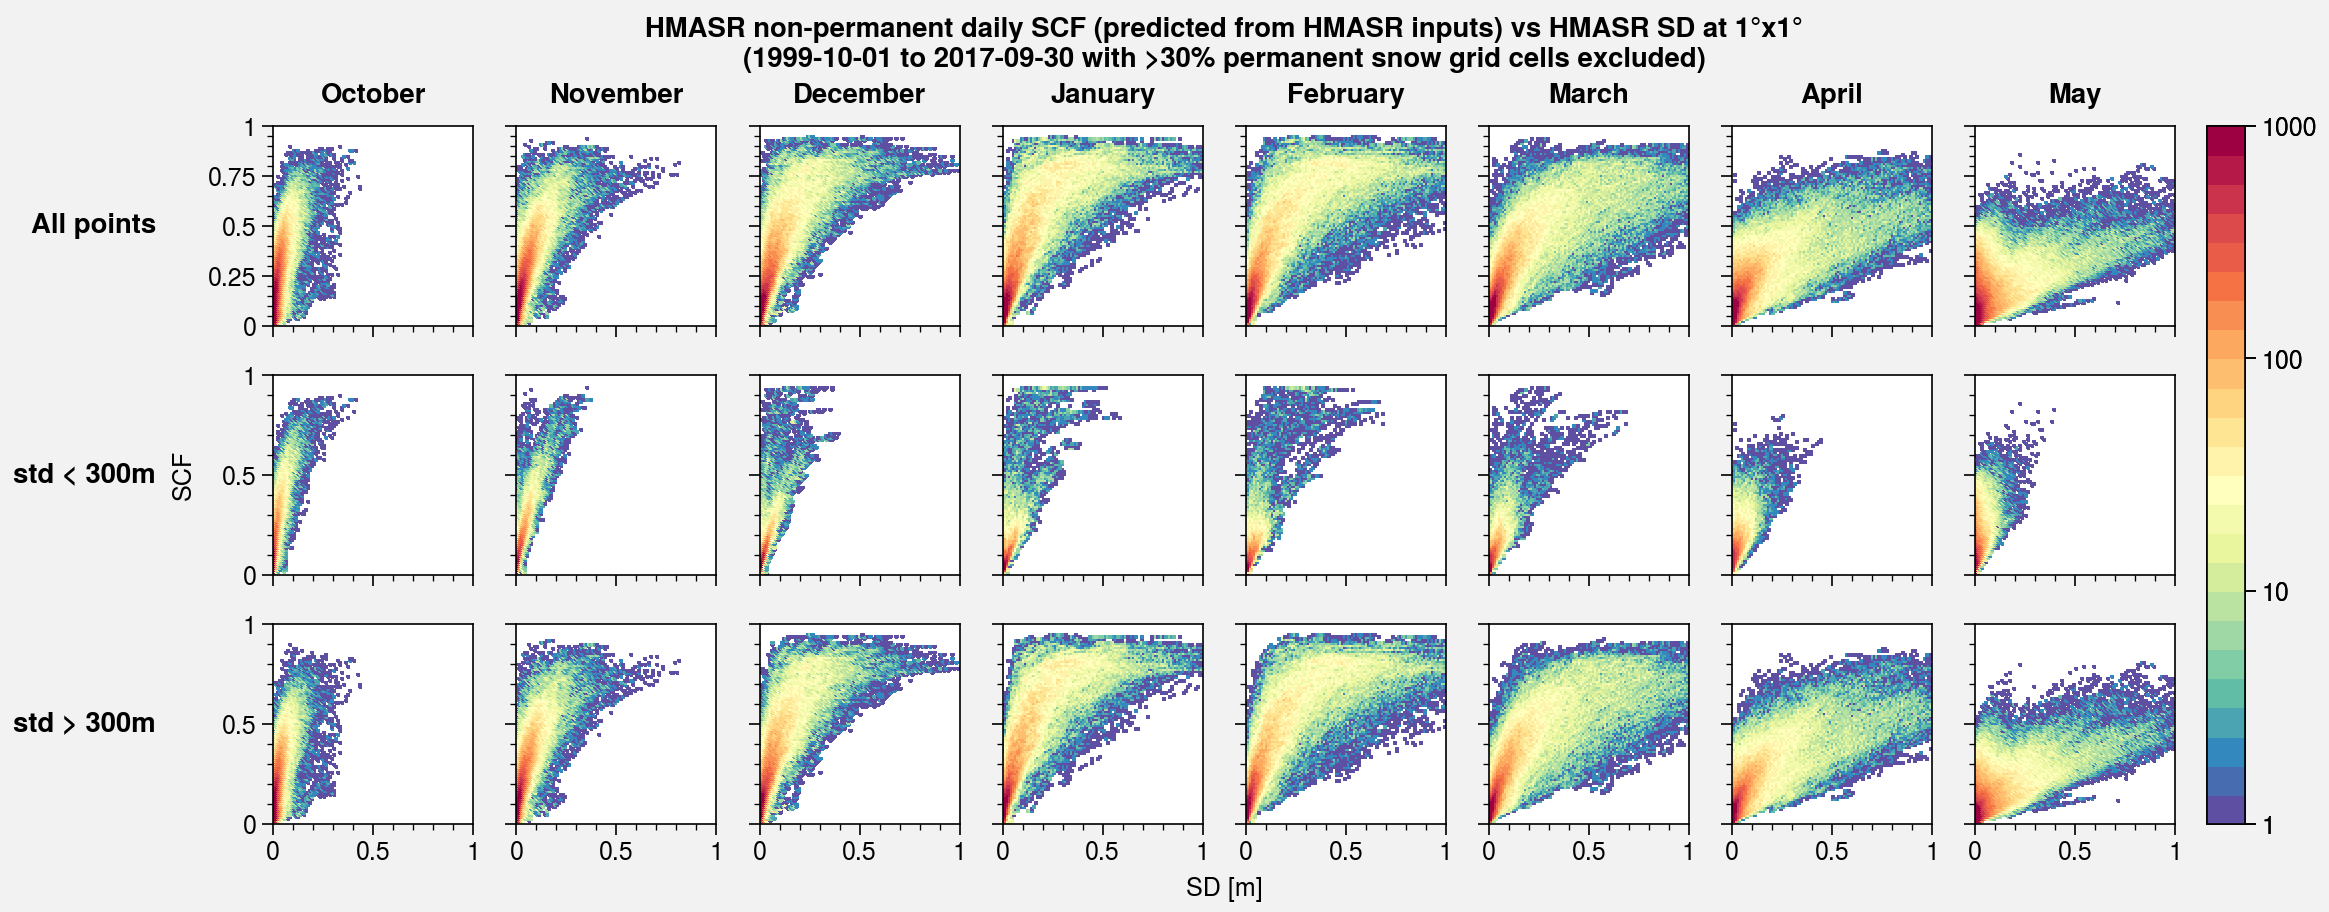

In [9]:
def plot_scf_vs_sd(scf, sd, param, save=False):
    xylim = [[0, 1], [0, 1]]
    bins = 100
    cmap = 'Spectral_r'
    levels = np.logspace(0, 3, 25)
    cmin = 1

    months = [10, 11, 12, 1, 2, 3, 4, 5]
    threshold = 300
    stds = [(True), (topo_std < threshold), (topo_std > threshold)]

    fig, axs = plot.subplots(ncols=len(months), nrows=3, axwidth=1)

    for j, std in enumerate(stds):
        for i, month in enumerate(months):
            ax = axs[j, i]
            m = ax.hist2d(
                sd.where( (sd['time.month'] == month) & (mask < 30) & std).values.flatten(),
                scf.where( (scf['time.month'] == month) & (mask < 30) & std).values.flatten(),
                bins=bins, range=xylim, cmap=cmap, cmin=cmin, levels=levels,
            )
            ax.format(xlabel='SD [m]', ylabel='SCF')

    fig.colorbar(m[3], ticks=np.logspace(0, 3, 4))

    axs.format(
        rowlabels=['All points', 'std < '+str(threshold)+'m', 'std > '+str(threshold)+'m'],
        collabels=[cld.month_name[month] for month in months],
        suptitle=param+' non-permanent daily SCF (predicted from HMASR inputs) vs HMASR SD at 1°x1°\n(1999-10-01 to 2017-09-30 with >30% permanent snow grid cells excluded)'
    )

    if save:
        fig.save('img/HMASR_SD_vs_'+param+'_SCF_100km_1999-2017_30_STD_400.jpg')

plot_scf_vs_sd(scf, sd, 'HMASR', save=False)

### Spatial SCF

In [10]:
def NY07(sd, z0, rho_snow, rho_new, m):
    scf = np.tanh(sd/(2.5*z0*(rho_snow/rho_new)**m))
    return scf.where((sd>1e-7) & (swe>1e-7) & (rho_snow<917), other=0).where( (sd*0+1) == 1).where(mask < 30)

scf_NY07_orig = NY07(sd, 0.01, swe/sd*1000, 100, 1.6)
scf_NY07_orch = NY07(sd, 0.01, swe/sd*1000, 50, 1)

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


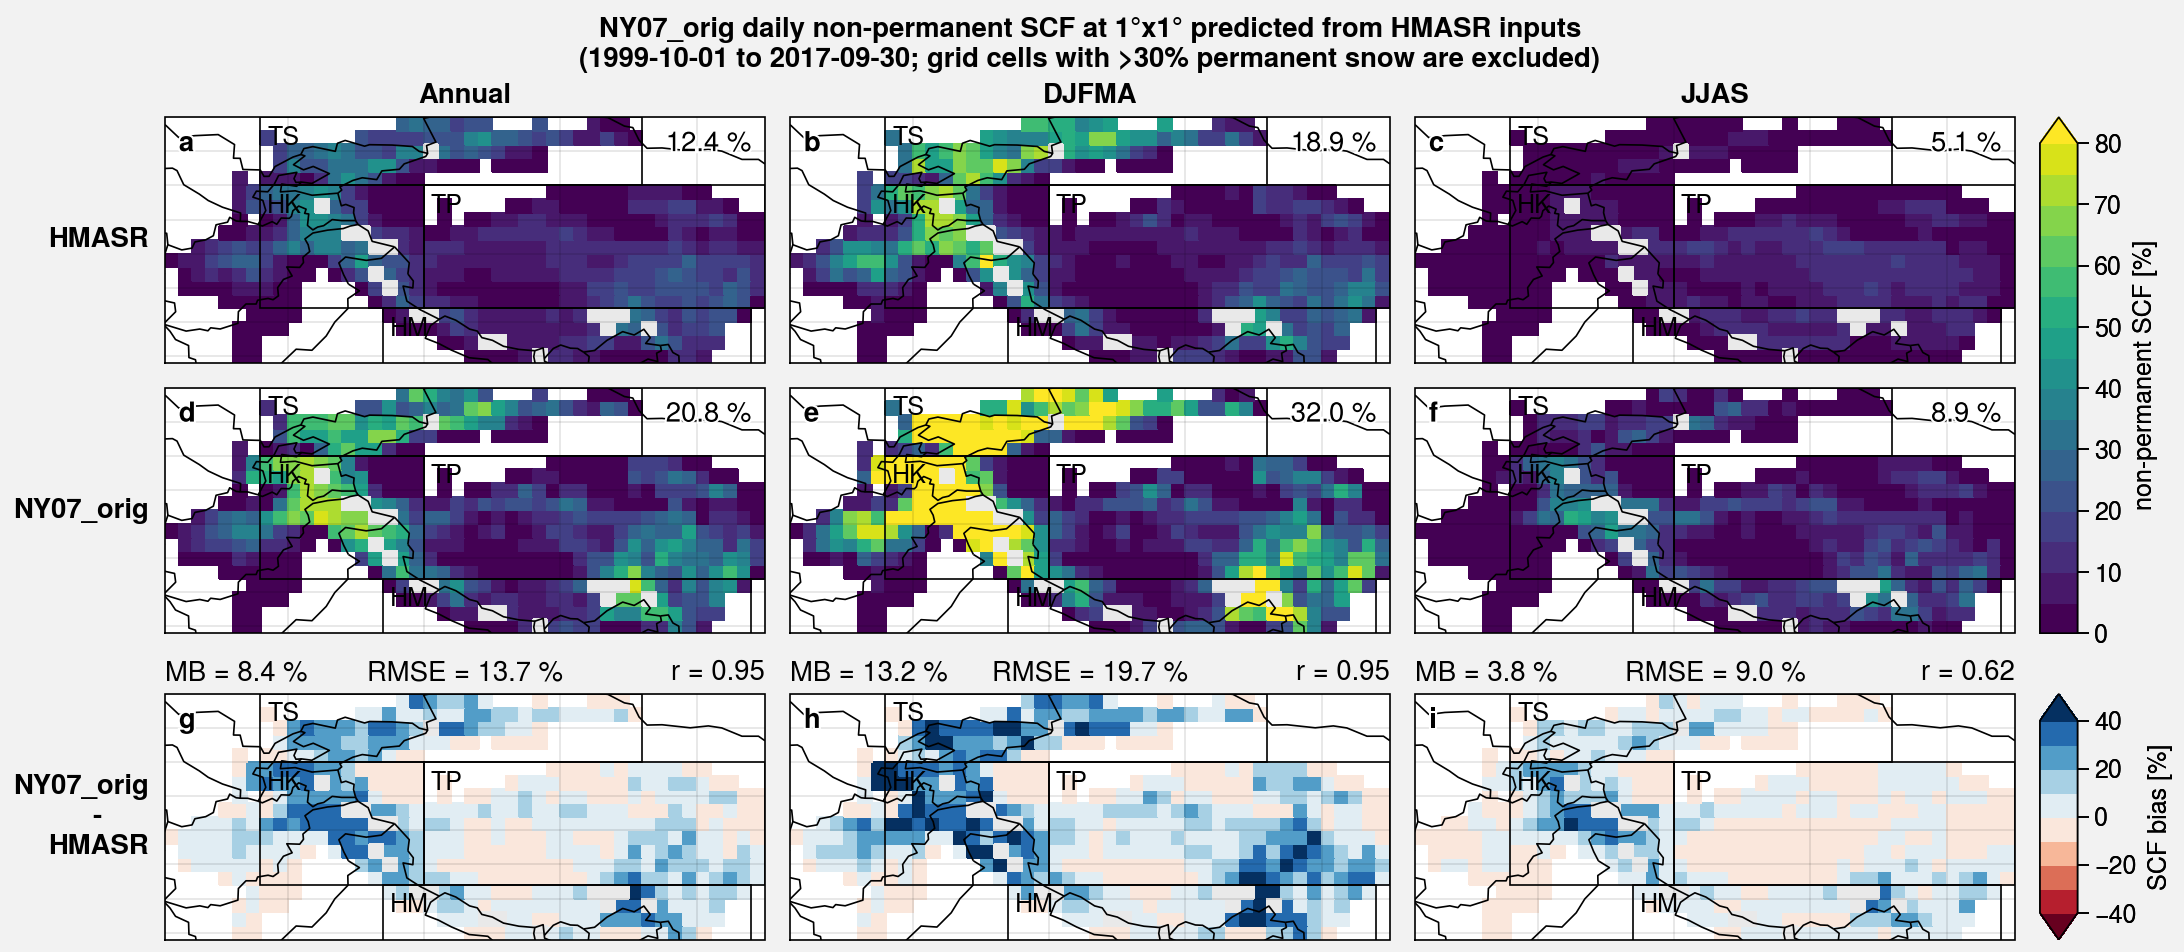

In [11]:
def plot_spatial_scf(scf_ref, scf_param, param, save=False):
    seasons=['Annual', 'DJFMA', 'JJAS']; fred='D'
    levels=plot.arange(0, 80, 5); extend='max'; cmap='viridis'
    levels_bias=plot.arange(-40, 40, 10); extend_bias='both'; cmap_bias='RdBu'
    threshold=30 # percentage of permanent snow in a cell

    fig, axs = plot.subplots(proj='cyl', ncols=len(seasons), nrows=3, axwidth=3)

    # HMASR
    for i, season in enumerate(seasons):
        data = u.clim(scf_ref, freq=fred, season=season, skipna=True)*100
        m = axs[0, i].pcolormesh(data, levels=levels, extend=extend, cmap=cmap)
        axs[0, i].format(urtitle='{:.1f} %'.format(data.weighted(weights).sum().values.item(0)))

    # param
    for i, season in enumerate(seasons):
        data = u.clim(scf_param, freq=fred, season=season, skipna=True)*100
        axs[1, i].pcolormesh(data, levels=levels, extend=extend, cmap=cmap)
        axs[1, i].format(urtitle='{:.1f} %'.format(data.weighted(weights).sum().values.item(0)))

    # bias
    for i, season in enumerate(seasons):
        scf_param_clim = u.clim(scf_param, freq=fred, season=season, skipna=True)*100
        scf_ref_clim = u.clim(scf_ref, freq=fred, season=season, skipna=True)*100
        
        m_bias = axs[2, i].pcolormesh(scf_param_clim-scf_ref_clim, levels=levels_bias, extend=extend_bias, cmap=cmap_bias)
        
        mb = u.weighted_mean(scf_param_clim-scf_ref_clim, weights).values.item(0)
        rmse = u.weighted_rmse(scf_param_clim, scf_ref_clim, weights).values.item(0)
        r = u.weighted_corr(scf_param_clim, scf_ref_clim, weights).values.item(0)
        axs[2, i].format(ltitle='MB = {:.1f} %'.format(mb), ctitle='RMSE = {:.1f} %'.format(rmse), rtitle='r = {:.2}'.format(r))

    # mask
    for ax in axs:
        ax.pcolormesh(mask.where(mask>threshold)*0+1, cmap='lightgray', levels=[0, 1, 2, 3])
        u.plot_zones(ax=ax)
    #     ax.format(utitle='aze')

    # Colorbars
    fig.colorbar(m, label='non-permanent SCF [%]', rows=(1, 2), ticks=10)
    fig.colorbar(m_bias, label='SCF bias [%]', row=3, ticks=20)

    # Format
    axs.format(
        borders=True, labels=False, 
        latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
        suptitle=param+' daily non-permanent SCF at 1°x1° predicted from HMASR inputs\n(1999-10-01 to 2017-09-30; grid cells with >30% permanent snow are excluded)',
        abc=True, abcloc='ul',
        collabels=seasons, rowlabels=['HMASR', param, param+'\n-      \nHMASR'],
    )
    
    if save:
        fig.save('img/HMASR_SCF_vs_'+param+'_SCF_100km_1999-2017_30.jpg')
    
plot_spatial_scf(scf, scf_NY07_orig, 'NY07_orig', save=False)

### Time series and annual cycle

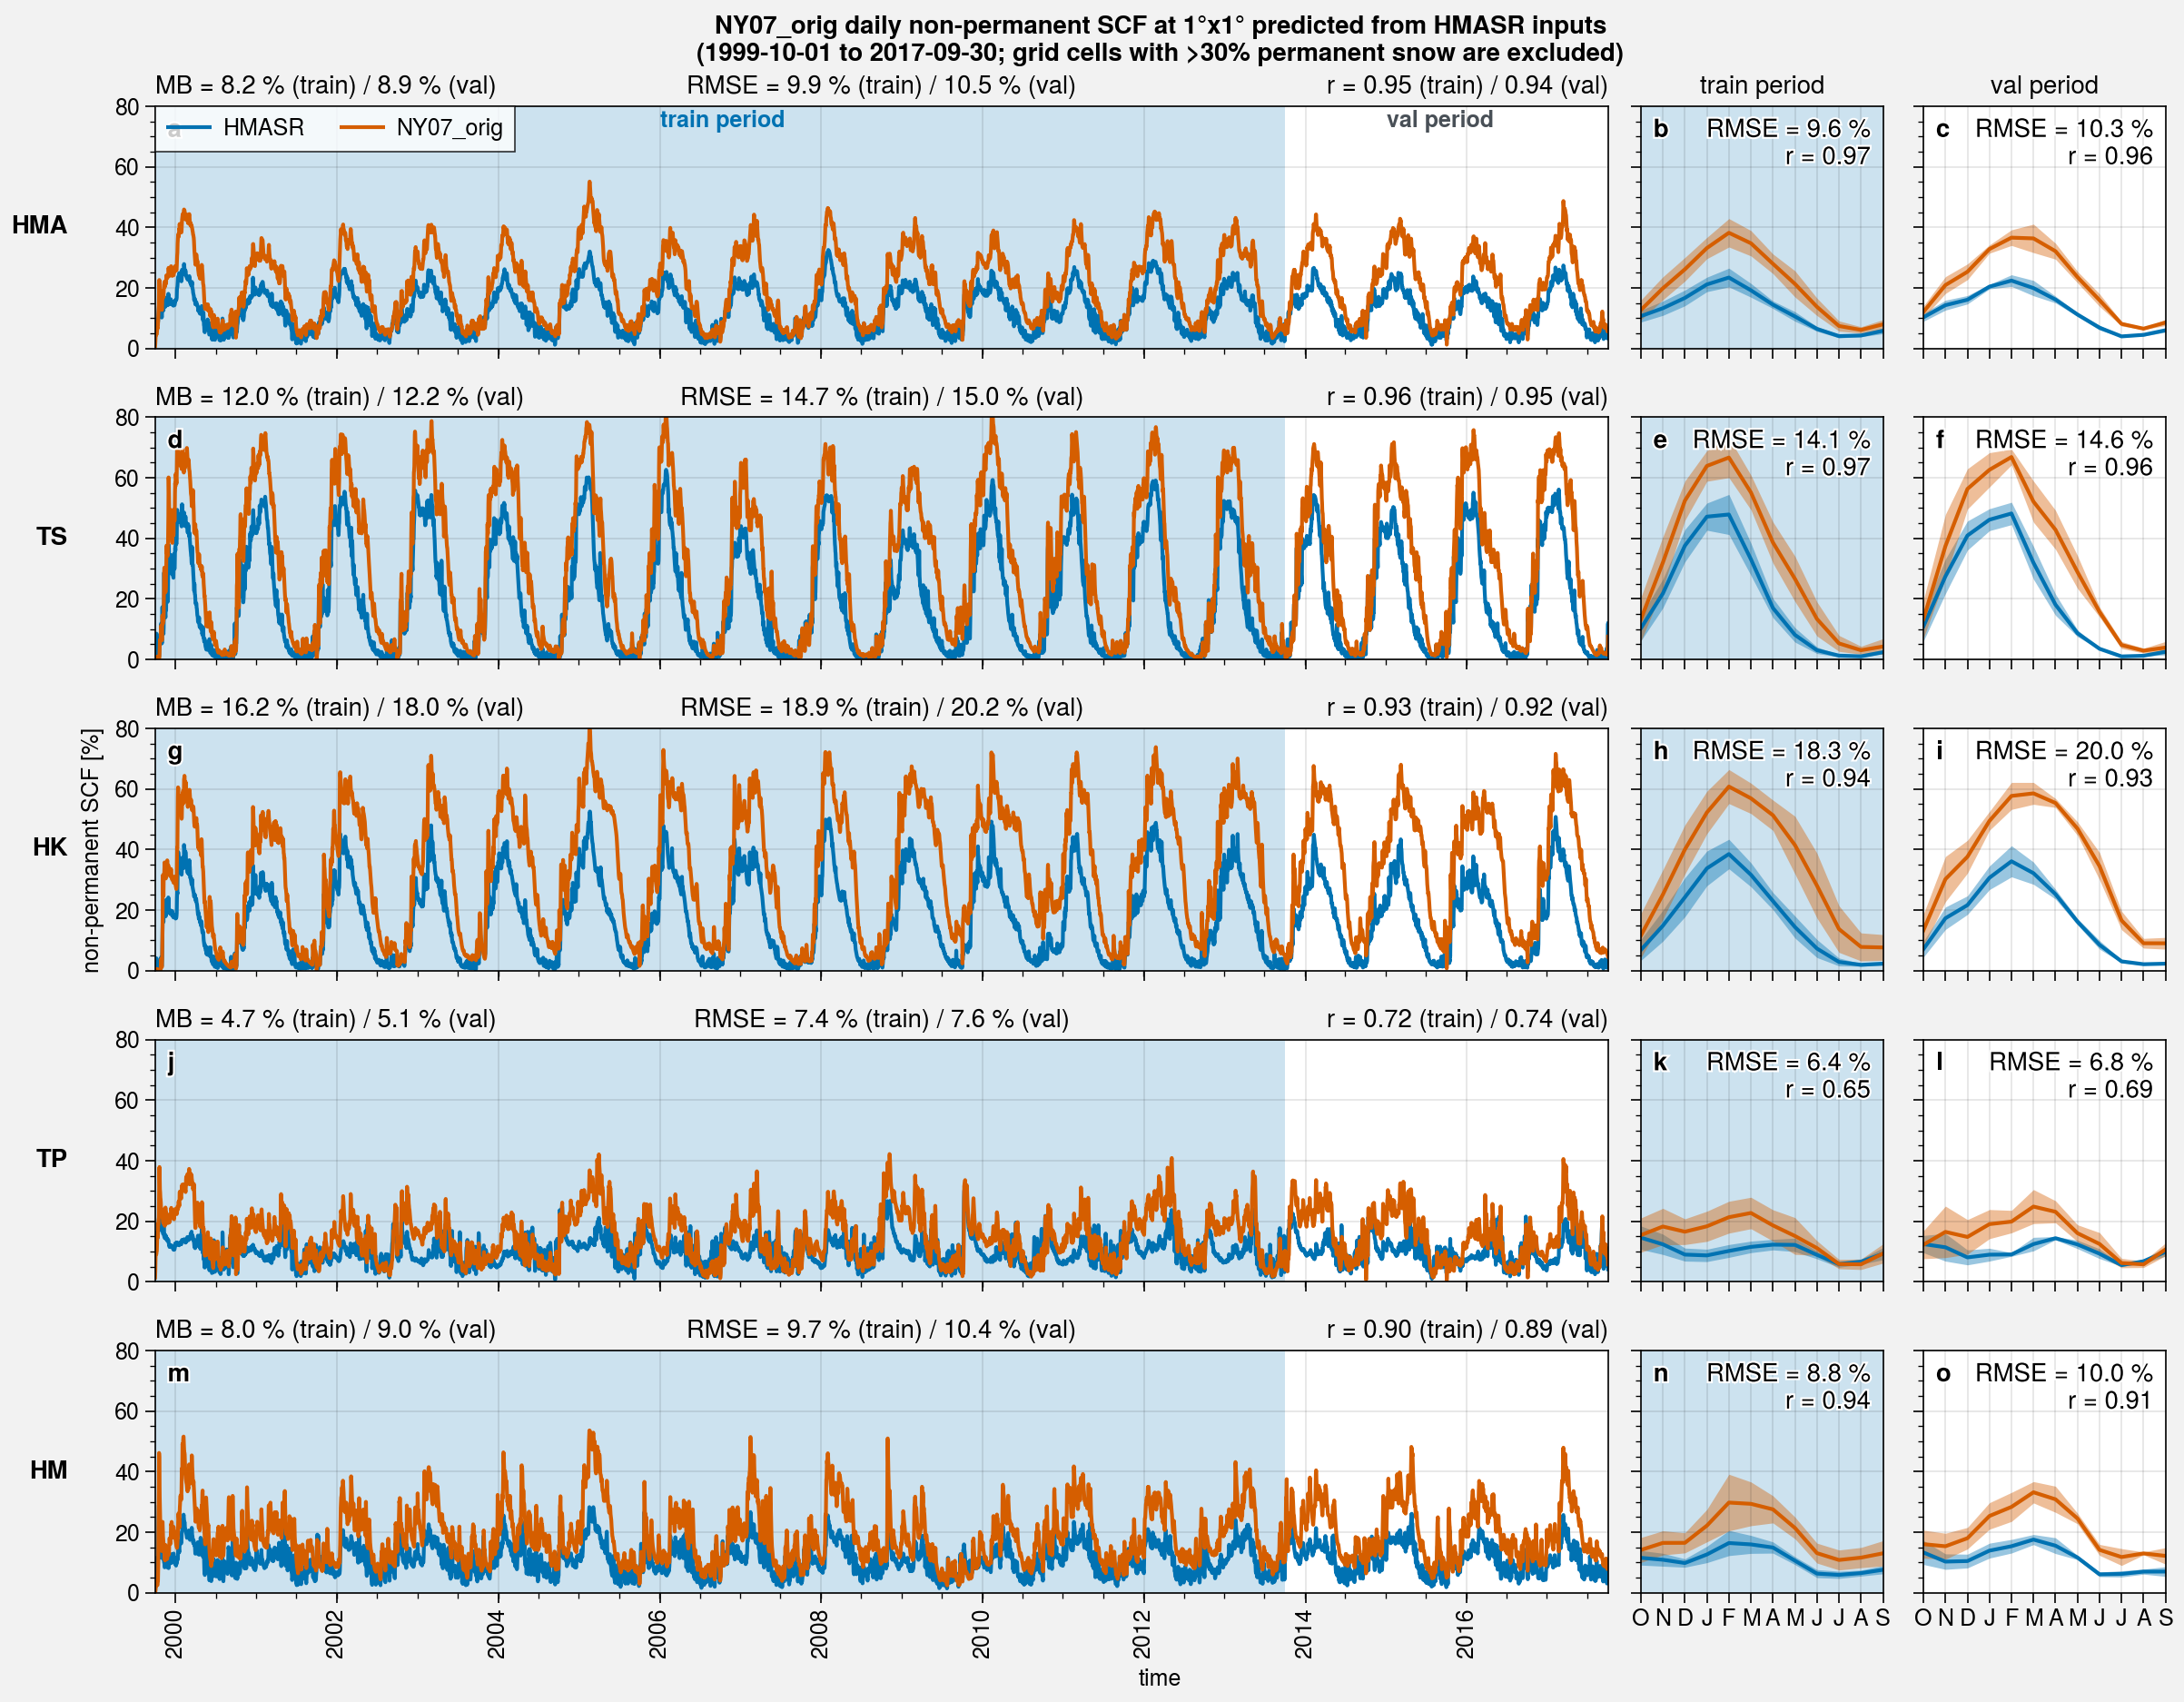

In [12]:
train_period = slice('1999-10-01', '2013-09-30') # ~80%
val_period = slice('2013-10-01', '2017-09-30') # ~20%

def plot_ts(scf_ref, scf_param, param, y_max=80, save=False):
    import warnings
    warnings.filterwarnings("ignore")
    zones = ['HMA', 'TS', 'HK', 'TP', 'HM']
    
    fig, axs = plot.subplots(nrows=len(zones), ncols=3, axwidth=8, ref=1, wratios=(6, 1, 1), aspect=6)

    ###################
    ### Time series ###
    ###################
    for i, zone in enumerate(zones):
        ax = axs[i, 0]


        ts_list = []
        for da, label in zip([scf_ref, scf_param], ['HMASR', param]):
            ts = da.sel(lat=zones_df.loc[zone].latlim, lon=zones_df.loc[zone].lonlim).weighted(weights).mean(('lat', 'lon'))*100
            ax.plot(ts, label=label)
            ts_list.append(ts)

        # Validation shading
#         ax.fill_between(da.sel(time=train_period).time, 0, y_max, alpha=0.2)
        ax.fill_between([da.time.values[0], da.sel(time=train_period).time.values[-1]], 0, y_max, alpha=0.2)

        # Compute metrics
        df = pd.DataFrame(index=['train', 'val'], columns=['mb', 'rmse', 'r'])
        for period, dataset in zip([train_period, val_period], ['train', 'val']):
            mb = (ts_list[1]-ts_list[0]).sel(time=period).mean().item(0)
            rmse = np.sqrt(((ts_list[1]-ts_list[0])**2).sel(time=period).mean().item(0))
            r = stats.pearsonr(ts_list[1].sel(time=period), ts_list[0].sel(time=period))[0]
            df.loc[dataset] = [mb, rmse, r]

        ax.format(
            ylabel='non-permanent SCF [%]',
            xlim=(da.time.values[0], da.time.values[-1]),
            ltitle='MB = {:.1f} % (train) / {:.1f} % (val)'.format(df.loc['train'].mb, df.loc['val'].mb),
            ctitle='RMSE = {:.1f} % (train) / {:.1f} % (val)'.format(df.loc['train'].rmse, df.loc['val'].rmse),
            rtitle='r = {:.2f} (train) / {:.2f} (val)'.format(df.loc['train'].r, df.loc['val'].r),
        )

    axs[0].text(np.datetime64('2006-01-01'), y_max-7, 'train period', color='C0', weight='bold')
    axs[0].text(np.datetime64('2015-01-01'), y_max-7, 'val period', color='gray7', weight='bold')
    axs[0].legend(loc='ul')

    ####################
    ### Annual cycle ###
    ####################
    for i, zone in enumerate(zones):
        for j, period in enumerate([train_period, val_period]):
            ax = axs[i, j+1]

            ac_list = []
            for da in [scf_ref, scf_param]:
                ac = da.sel(lat=zones_df.loc[zone].latlim, lon=zones_df.loc[zone].lonlim, time=period) \
                            .groupby('time.month').mean() \
                            .weighted(weights).mean(('lat', 'lon'))*100
                std = da.sel(lat=zones_df.loc[zone].latlim, lon=zones_df.loc[zone].lonlim, time=period) \
                            .weighted(weights).mean(('lat', 'lon')) \
                            .resample(time='M').mean() \
                            .groupby('time.month').std()*100

                ac_list.append(ac)

                ac_shift = ac.reindex(month=np.roll(ac.month,3))
                std_shift = std.reindex(month=np.roll(std.month,3))
                shadedata = [(ac_shift-std_shift).values, (ac_shift+std_shift).values]

                ax.plot(ac_shift.values, shadedata=shadedata, label='SCF')

            if j == 0:
                # Validation shading
                ax.fill_between(range(12), 0, y_max, alpha=0.2)


            # Compute metrics
            mb = (ac_list[1]-ac_list[0]).mean().item(0)
            rmse = np.sqrt(((ac_list[1]-ac_list[0])**2).mean().item(0))
            r = stats.pearsonr(ac_list[1], ac_list[0])[0]

            ax.format(
                xlocator='index', xformatter=[cld.month_abbr[month][0] for month in ac.reindex(month=np.roll(ac.month,3)).month.values],
                urtitle='RMSE = {:.1f} %\nr = {:.2f}'.format(rmse, r),
            )


    axs[1].format(title='train period')
    axs[2].format(title='val period')

    for ax in axs:
        ax.autoscale(tight=True)

    axs.format(
        suptitle=param+' daily non-permanent SCF at 1°x1° predicted from HMASR inputs\n' \
                 '(1999-10-01 to 2017-09-30; grid cells with >30% permanent snow are excluded)',
        rowlabels=zones,
        abc=True, abcloc='ul',
        ylim=(0, y_max), ylabel='non-permanent SCF [%]',
    )
    
    if save:
        fig.save('img/HMASR_vs_'+param+'_SCF_ts_ac_100km_1999-2017_30.jpg')
    
plot_ts(scf, scf_NY07_orig, 'NY07_orig', y_max=80, save=False)

In [13]:
def plots(scf_param, name, y_max=80, save=False):
    plot_scf_vs_sd(scf_param, sd, name, save=save)
    plot_spatial_scf(scf, scf_param, name, save=save)
    plot_ts(scf, scf_param, name, y_max=y_max, save=save)

## Roesch et al. 2001

\begin{equation}
\text{SCF} = 0.95 \cdot \tanh \left(100 \cdot \text{SWE} \right) \sqrt{\frac{1000 \cdot \text{SWE} }{1000 \cdot \text{SWE} + \varepsilon + 0.15 \cdot \sigma_{topo}}}
\label{eq:R01}
\end{equation}


In [14]:
def R01(swe, zstd):
    return 0.95 * np.tanh(100*swe) * np.sqrt( 1000*swe / ( 1000*swe + 0.15*zstd + 1e-6) )

scf_R01 = R01(swe, topo_std)

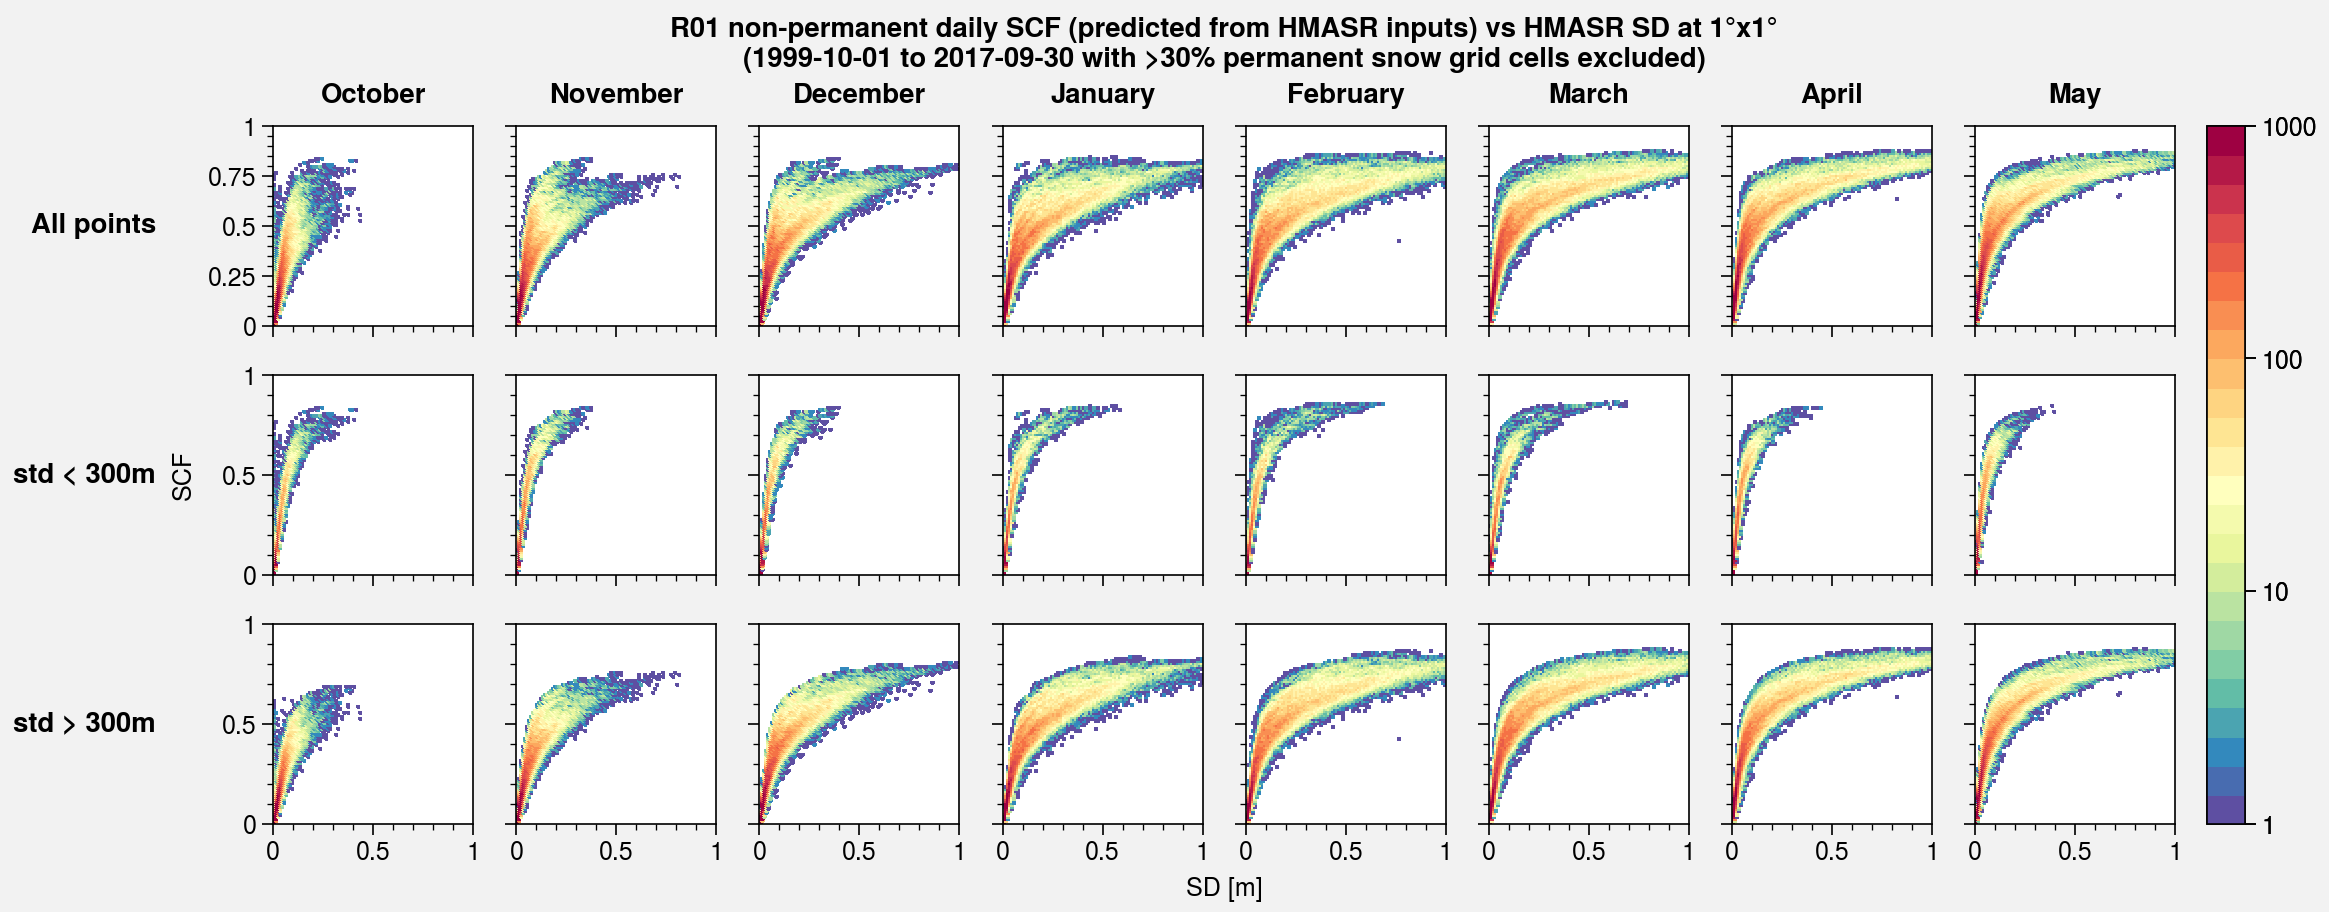

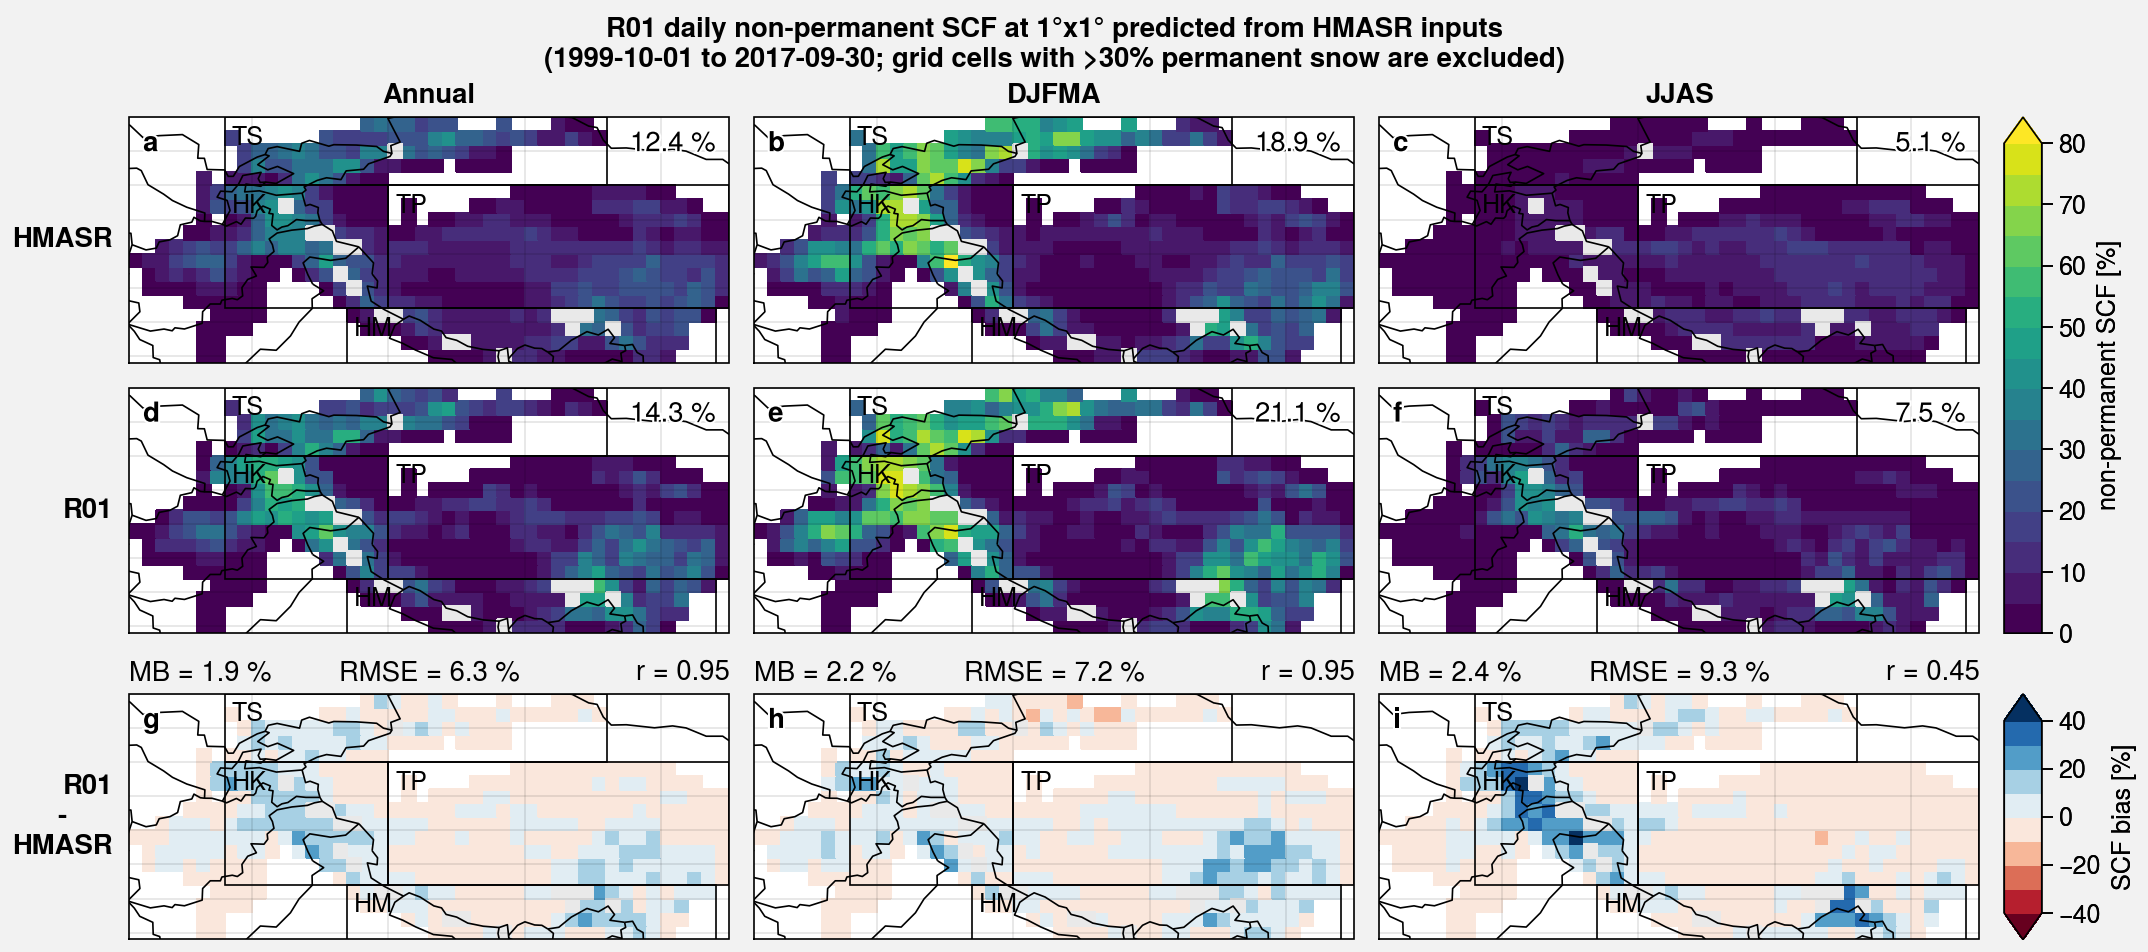

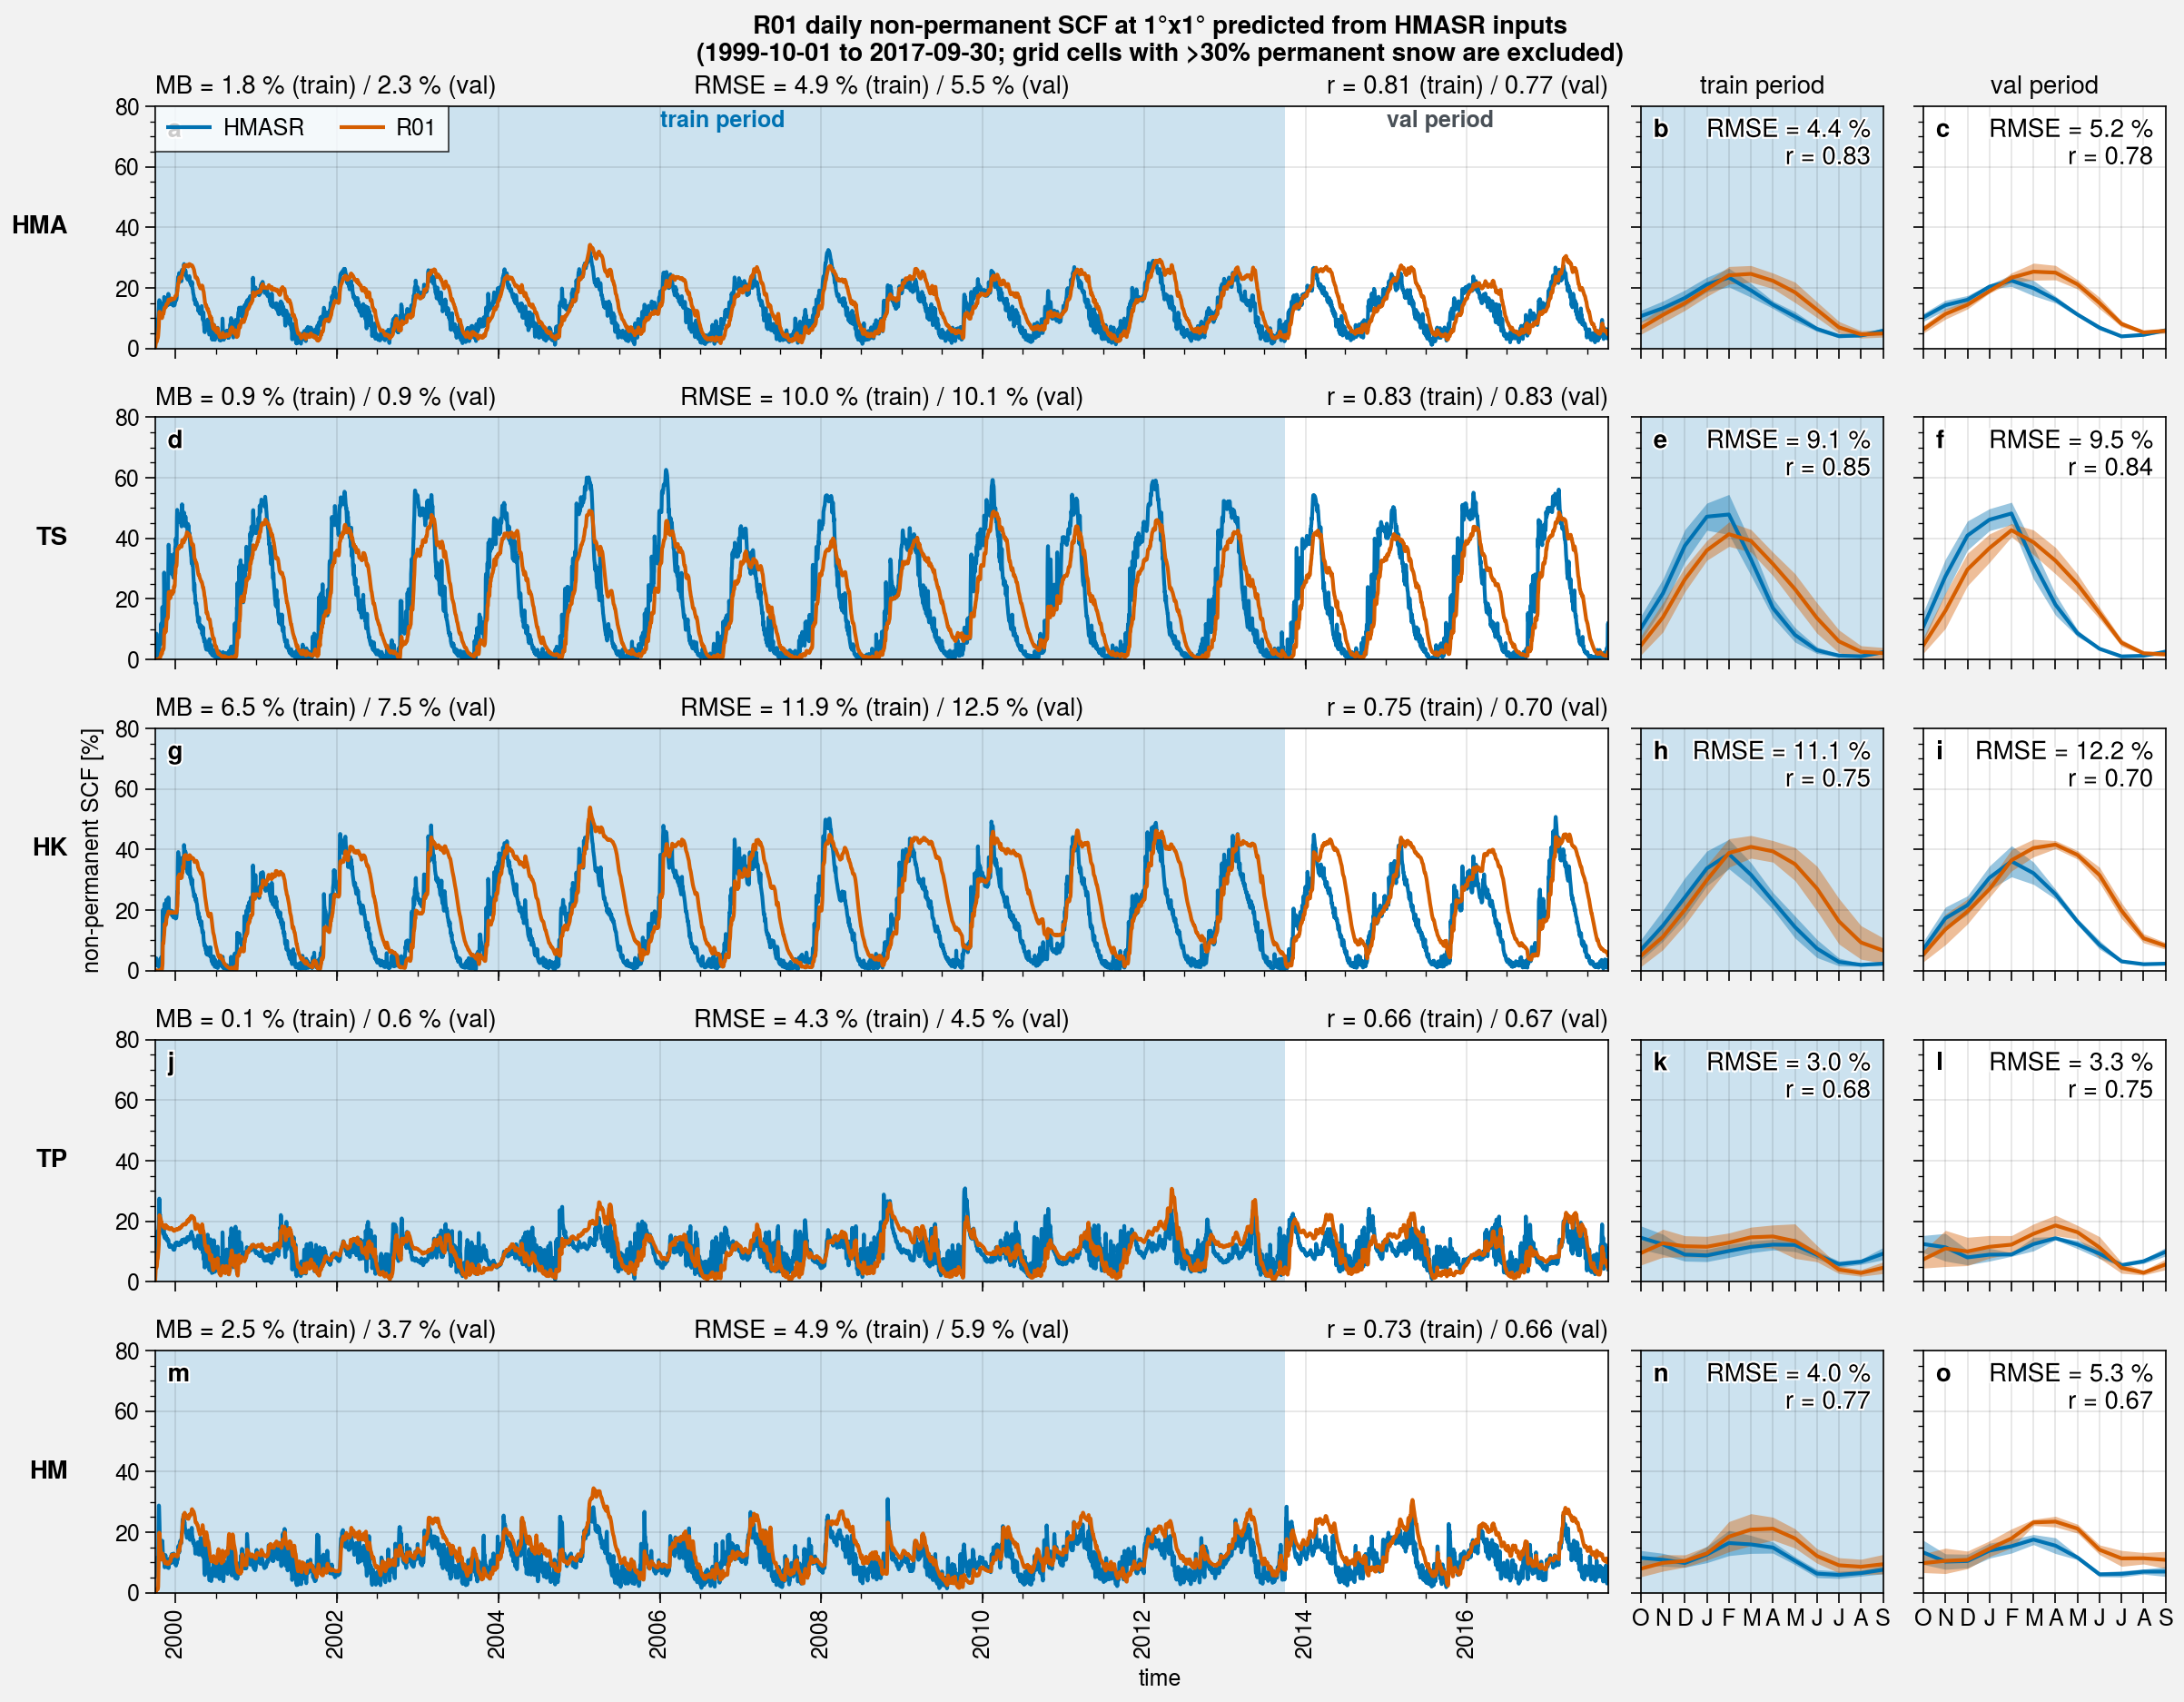

In [60]:
plots(scf_R01, 'R01', save=False)

In [39]:
w = scf.copy(); w[:] = weights
mse = u.weighted_rmse(scf.sel(time=train_period), scf_R01.sel(time=train_period), w.sel(time=train_period))**2
print('MSE = {:0.3f}'.format(mse.item(0)) + ' / RMSE = {:0.3f}'.format(np.sqrt(mse.item(0))) + ' ({:0.1f} %)'.format(np.sqrt(mse.item(0))*100))

MSE = 0.017 / RMSE = 0.131 (13.1 %)


In [40]:
w = scf.copy(); w[:] = weights
mse = u.weighted_rmse(scf.sel(time=val_period), scf_R01.sel(time=val_period), w.sel(time=val_period))**2
print('MSE = {:0.3f}'.format(mse.item(0)) + ' / RMSE = {:0.3f}'.format(np.sqrt(mse.item(0))) + ' ({:0.1f} %)'.format(np.sqrt(mse.item(0))*100))

MSE = 0.019 / RMSE = 0.138 (13.8 %)


### Optimization

In [21]:
def R01_opti(swe, zstd, alpha, beta):
    return 0.95 * np.tanh(100*swe) * ( 1000*swe / ( 1000*swe + alpha*zstd + 1e-6) )**beta

In [43]:
# https://stackoverflow.com/questions/13670333/multiple-variables-in-scipys-optimize-minimize
import scipy.optimize as optimize

def f(params):
    alpha, beta = params 
    w = scf.copy(); w[:] = weights
    mse = u.weighted_rmse(scf.sel(time=train_period), R01_opti(swe.sel(time=train_period), topo_std, alpha, beta), w.sel(time=train_period))**2
    return mse

initial_guess = [0.15, 0.5]
result = optimize.minimize(f, initial_guess, method='nelder-mead')
if result.success:
    fitted_params = result.x
    print(fitted_params)
    print('MSE = {:0.3f}'.format(result.fun) + ' / RMSE = {:0.3f}'.format(np.sqrt(result.fun)) + ' ({:0.1f} %)'.format(np.sqrt(result.fun)*100))
else:
    raise ValueError(result.message)

[1.14542409 0.31907049]
MSE = 0.012 / RMSE = 0.111 (11.1 %)


In [53]:
scf_R01_opti = R01_opti(swe, topo_std, 1.14542409, 0.31907049)

In [61]:
scf_R01_opti = R01_opti(swe, topo_std, 1.15, 0.3)

In [58]:
w = scf.copy(); w[:] = weights
mse = u.weighted_rmse(scf.sel(time=train_period), scf_R01_opti.sel(time=train_period), w.sel(time=train_period))**2
print('MSE = {:0.3f}'.format(mse.item(0)) + ' / RMSE = {:0.3f}'.format(np.sqrt(mse.item(0))) + ' ({:0.1f} %)'.format(np.sqrt(mse.item(0))*100))

MSE = 0.012 / RMSE = 0.111 (11.1 %)


In [50]:
w = scf.copy(); w[:] = weights
mse = u.weighted_rmse(scf.sel(time=val_period), scf_R01_opti.sel(time=val_period), w.sel(time=val_period))**2
print('MSE = {:0.3f}'.format(mse.item(0)) + ' / RMSE = {:0.3f}'.format(np.sqrt(mse.item(0))) + ' ({:0.1f} %)'.format(np.sqrt(mse.item(0))*100))

MSE = 0.013 / RMSE = 0.114 (11.4 %)


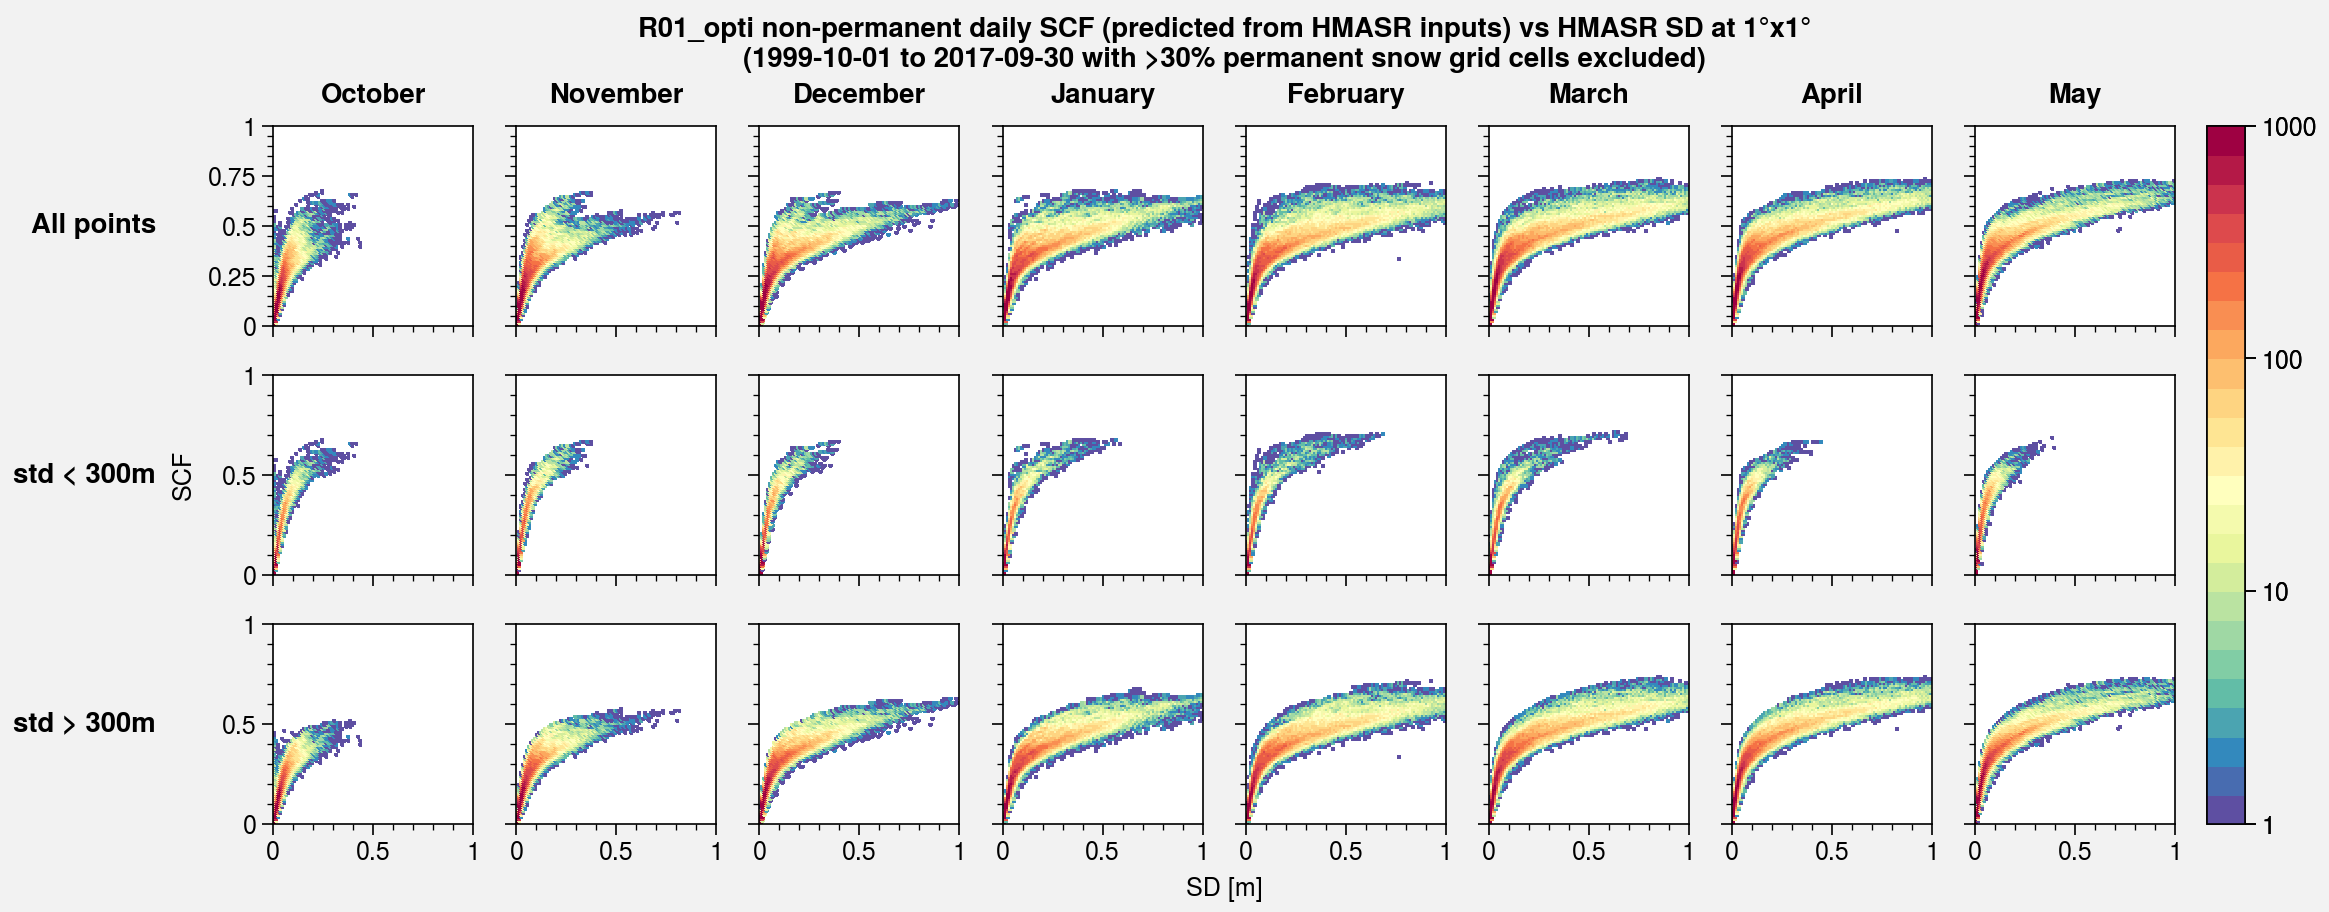

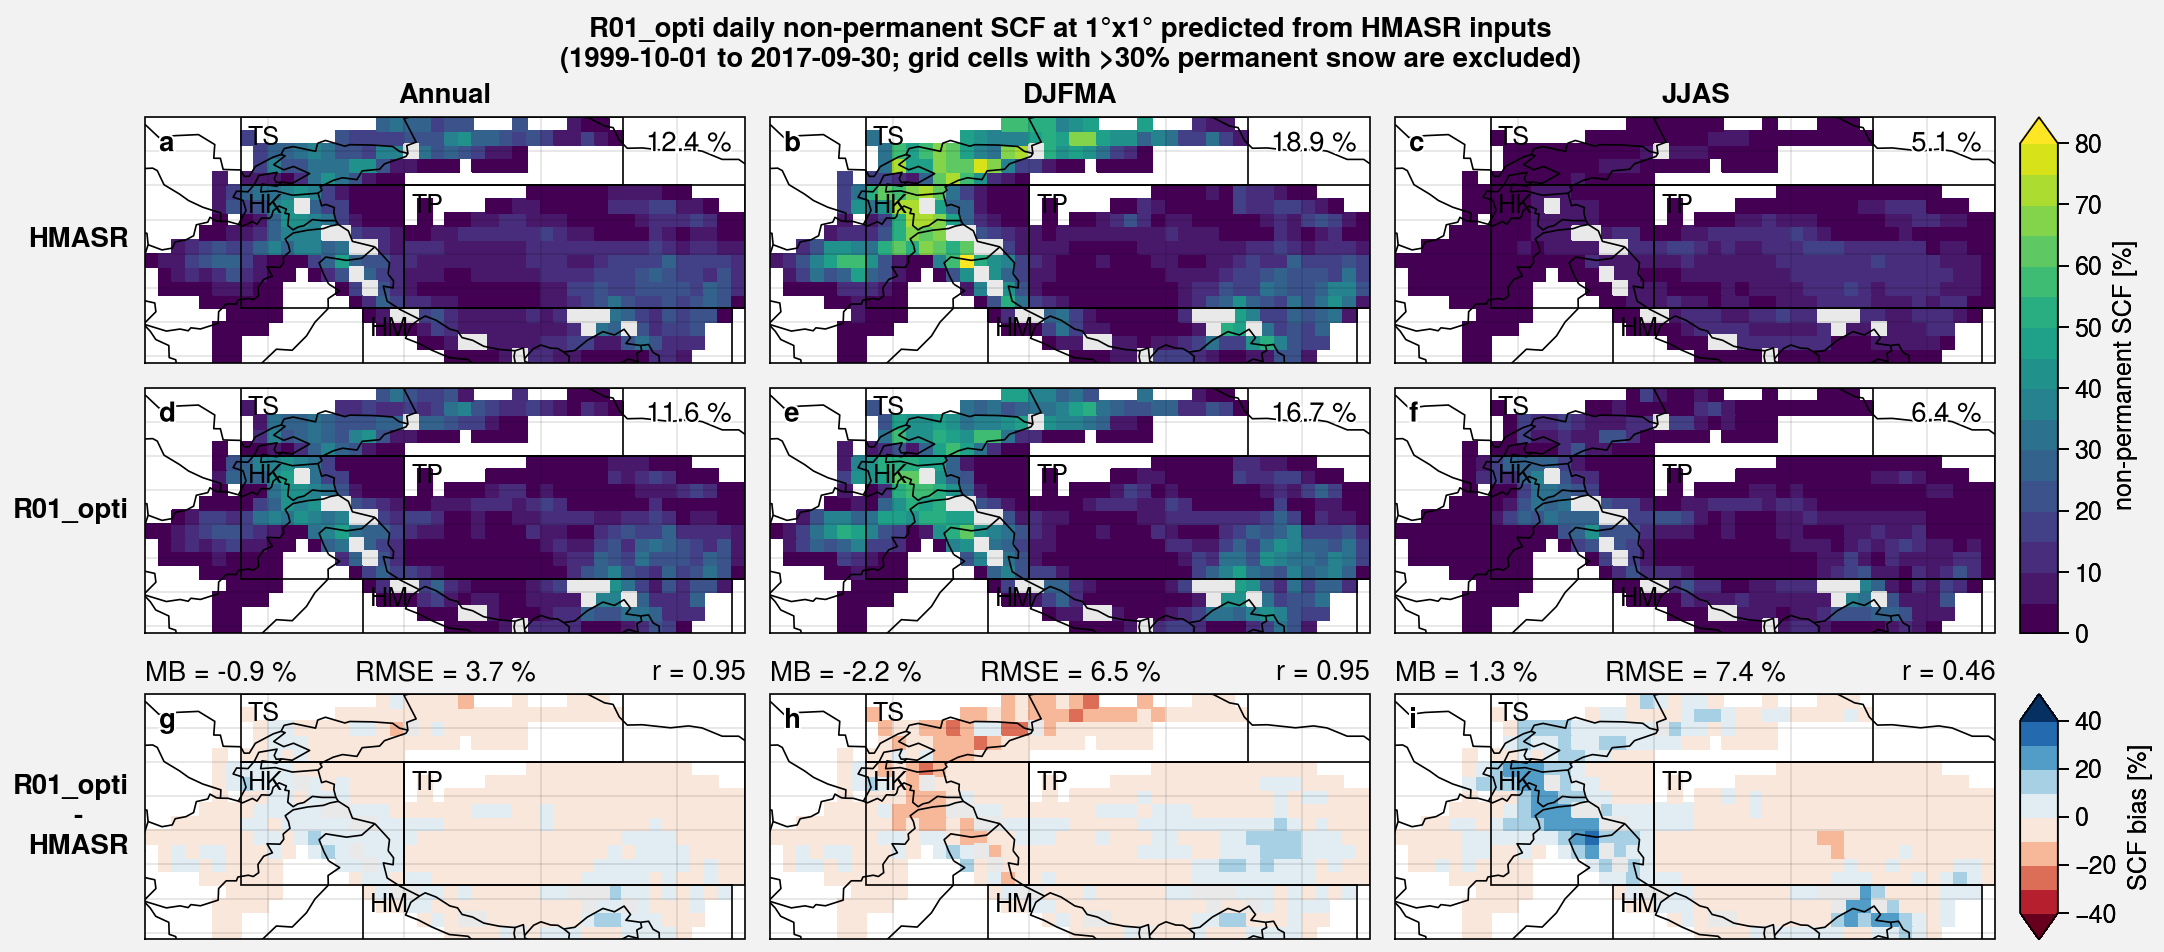

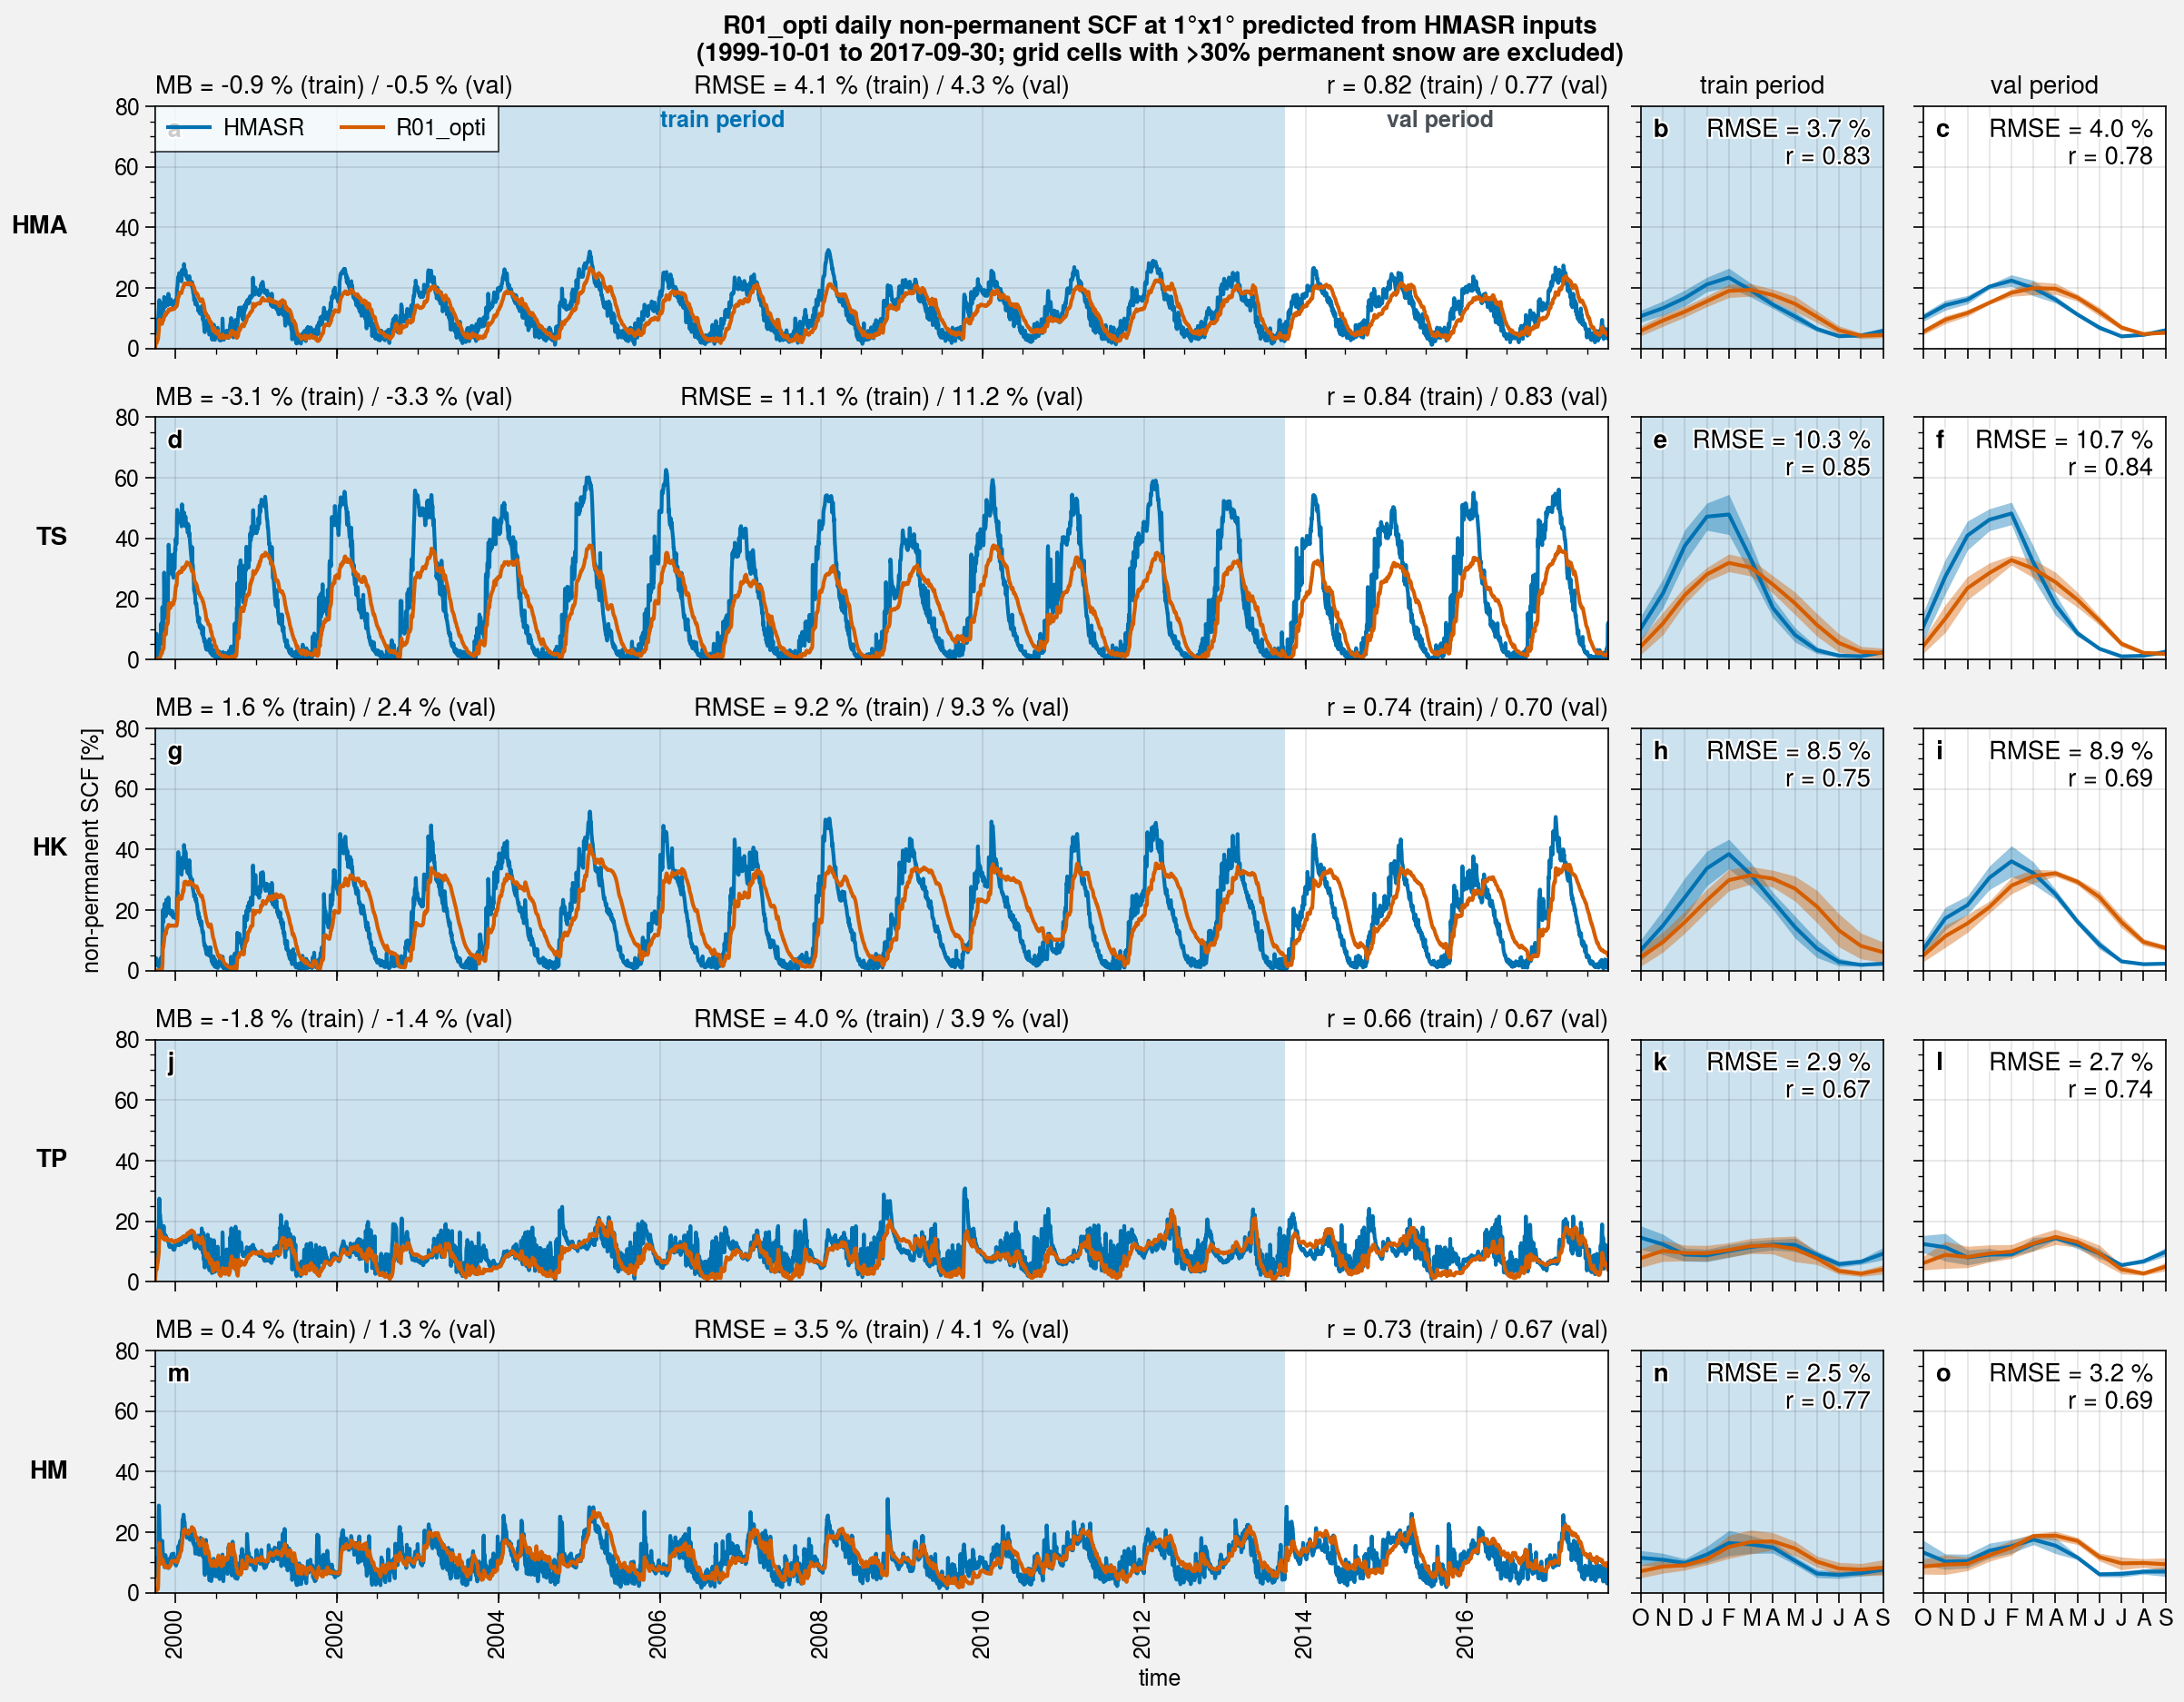

In [62]:
plots(scf_R01_opti, 'R01_opti', save=True)

## Common graph